In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances
from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048

do_training = True
load_model = False
save_model = False
seed = 42

ae_loss = 'emd'

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
experiment_name = 'ae_'+ ae_loss +'_1c_gan_'+ class_name +'_' + str(n_pc_samples) +  '_pts'

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'

train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/ae_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_emd_1c_gan_chair_2048_pts'

In [42]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [45]:

outf = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/gt_all_' + class_name
np.savez(outf, pclouds)



In [6]:
# Load Auto-Encoder
reset_tf_graph()

# ae_net_name = '1_three_fc_dec_with_spn_' + str(n_pc_samples) +  'pts_' + ae_loss
ae_net_name = class_name + '_three_fc_dec_' + str(n_pc_samples) +  'pts_' + ae_loss

ae_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
saved_epochs = read_saved_epochs(ae_conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 500.


In [7]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [16]:
reset_tf_graph()
init_lr = 0.00005
n_out = latent_codes.shape[1]
gan = LatentGAN(experiment_name, learning_rate=init_lr, n_output=[n_out])
train_stats = []
accum_syn_data = []

In [10]:
if load_model:
    saved_epochs = read_saved_epochs(train_dir)
    last_epoch = saved_epochs[-1]
    gan.restore_model(train_dir, last_epoch, verbose=True)

In [17]:
n_syn_samples = 1000
max_epochs = 10
batch_size = 50
noise_params = {'mu':0, 'sigma': 1}
    
if do_training:
    for _ in range(max_epochs):
        
#         checkpoint_path = osp.join(train_dir, model_saver_id)
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss

        syn_latent_data = gan.generate(n_syn_samples, noise_params)
        syn_data = ae.decode(syn_latent_data)
        accum_syn_data.append(syn_data)
                
#         if save_model:
#             gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)
        

1 (0.66816268739876927, 2.9078244774429884)
2 (0.051216556628545122, 7.1248828923260721)
3 (0.01928029355627519, 9.2275966785572194)
4 (0.01969886135171961, 8.9584702244511352)
5 (0.021563787710059571, 8.21988341720016)
6 (0.035424171553717722, 7.8216582757455333)
7 (0.091221383793486488, 6.5879933639808934)
8 (0.09431783648000823, 5.8011090525874387)
9 (0.097452214801753007, 5.4972389751010473)
10 (0.1097875978383753, 5.2186389410937277)


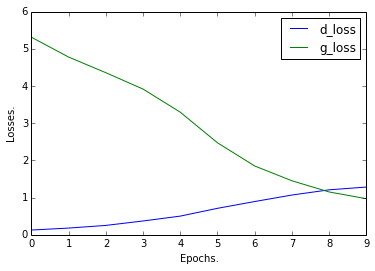

In [13]:
x = range(len(train_stats))
d_loss = [t[1] for t in train_stats]
g_loss = [t[2] for t in train_stats]
plt.plot(x, d_loss)
plt.plot(x, g_loss)
plt.legend(['d_loss', 'g_loss'], loc=0)
plt.xlabel('Epochs.')
plt.ylabel('Losses.')

In [19]:
entropies = []
emd_dists = []
for sdata in accum_syn_data:
    entropies.append(entropy_of_occupancy_grid(sdata, 32))
    emd_dists.append(point_cloud_distances(sdata, 10, gan.sess, 'emd'))
plt.plot(range(len(mean_emd_dists)), mean_emd_dists)

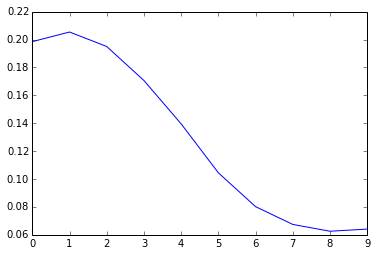

In [20]:
plt.plot(range(len(entropies)), entropies)

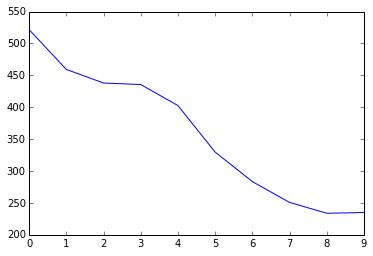

In [41]:
# mean_emd_dists = [np.mean(i) for i in emd_dists]


In [37]:
rindex = np.random.choice(np.arange(n_syn_samples), size=5, replace=False)
di = accum_syn_data[0]

for pc in di[rindex]:
    Point_Cloud(pc).plot()

IndexError: list index out of range

In [38]:
entropies

[0.1984797197057015,
 0.20536642068107427,
 0.19498980092242815,
 0.17060522072874418,
 0.13954920667710172,
 0.10447704110157868,
 0.080195659856730453,
 0.067442013618748173,
 0.06255487874323315,
 0.064081573474364328]

In [11]:
# # Swap axis and save
n_samples = 1000
syn_latent_data = gan.generate(n_samples, noise_params)
syn_data = ae.decode(syn_latent_data)

syn_data_rot = np.empty_like(syn_data)
for i, pc in enumerate(syn_data):
    syn_data_rot[i] = pc[:, [0, 2, 1]]
    pc = Point_Cloud(syn_data_rot[i]).center_in_unit_sphere()
    syn_data_rot[i] = pc.points

# save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch))
# np.savez(save_out, syn_data_rot)


0.064890976298144123

In [71]:
# np.vstack(accum_syn_data).shape
# # # entropy_of_occupancy_grid(ae.decode(gan.generate(n_samples, noise_params)), 32)
# # # entropy_of_occupancy_grid(syn_data, 32)

# # entropy_of_occupancy_grid(np.vstack(accum_syn_data), 32)

# # gro = []
# # for i in accum_syn_data:
# #     gro += i[]
# # # len(accum_syn_data)

# # # accum_syn_data[0]

# # len(gro)

# # np.random.sample(np.arange(10))/
# lala = np.random.choice(np.arange(5000), size=1000, replace=False)
# entropy_of_occupancy_grid(np.vstack(accum_syn_data)[lala], 32)

(500, 2048, 3)